In [ ]:
!pip install opendatasets
!pip install pandas
!pip install cython
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms ,models
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [ ]:
data_dir = '../content/drive/MyDrive/New_chest_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [ ]:
batch_size = 32

In [ ]:
# TODO: Define transforms for the training, validation, and testing sets
data_transforms = transform = {
        'train': transforms.Compose(
            [transforms.Resize([224, 224]),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomAffine(degrees=20, translate=(.2,.2), scale=None, shear=(.2,.2,.2,.2)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'test': transforms.Compose(
            [transforms.Resize([224, 224]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
        'valid': transforms.Compose(
            [transforms.Resize([224, 224]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])
                }

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test' : datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
}
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
    'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=True),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=batch_size, shuffle=True)
}

In [ ]:
#File Operation libraries
import glob
from pathlib import Path
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
def get_df(path):
    lst = []
    normal_dir = Path(path + "/NORMAL")
    pneumonia_dir = Path(path + "/PNEUMONIA")
    normal_data = normal_dir.glob("*.jpeg")
    pneumonia_data = pneumonia_dir.glob("*.jpeg")
    for fname in normal_data:
        lst.append((fname, 0))
    for fname in pneumonia_data:
        lst.append((fname, 1))
    df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
    s = np.arange(df.shape[0])
    np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    return df


In [ ]:
df_train = get_df(train_dir)
df_valid = get_df(valid_dir)
df_test = get_df(test_dir)

In [ ]:
print(df_train.shape,df_valid.shape,df_test.shape)
print(df_train['Label'].value_counts())
print(df_test['Label'].value_counts())
print(df_valid['Label'].value_counts())

(26709, 2) (1040, 2) (0, 2)
1    20687
0     6022
Name: Label, dtype: int64
Series([], Name: Label, dtype: int64)
1    773
0    267
Name: Label, dtype: int64


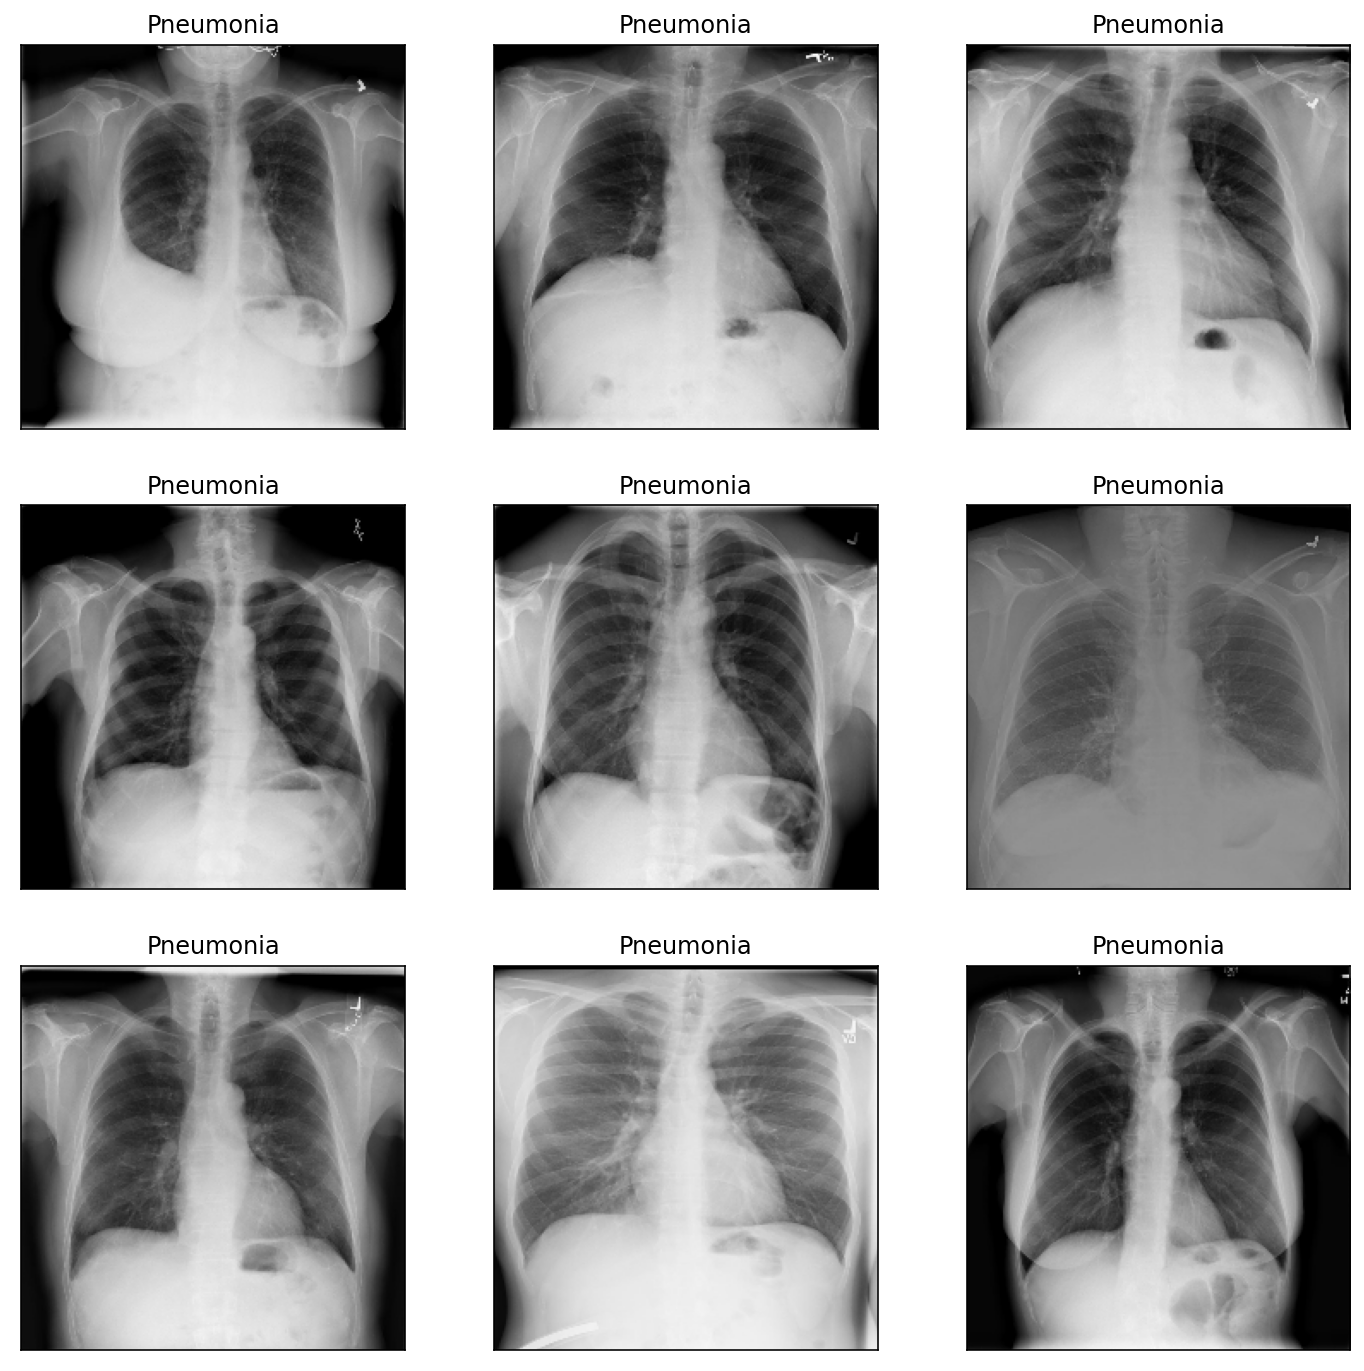

In [ ]:
#Image Transformation Libraries
import cv2
from imgaug import augmenters as iaa

def transform_image(img_list):
    img = cv2.resize(img_list, (224, 224))
    #cv2 reads image in BGR format. Let's convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

fig, ax = plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
model_dens = models.densenet161(pretrained=True)
dens_classifier = nn.Sequential(OrderedDict([


                      ('fc1', nn.Linear(2208, 1024)),
                      ('bn1', nn.BatchNorm1d(1024)),
                      ('out1', nn.Dropout(0.5)),
                      ('relu1', nn.ReLU(inplace=True)),

                      ('fc2', nn.Linear(1024, 512)),
                      ('bn2', nn.BatchNorm1d(512)),
                      ('out2', nn.Dropout(0.2)),
                      ('relu2', nn.ReLU(inplace=True)),




                     ('logits', nn.Linear(512, 2)),
                    ('output', nn.LogSoftmax(dim=1))]))
model_dens.classifier=dens_classifier
model_dens

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dens.classifier.parameters(), lr=0.001)

In [ ]:
epochs = 5
print_every = 40
steps = 0
running_loss = 0

In [ ]:
for param in model_dens.parameters():
    param.requires_grad = True

In [ ]:
use_gpu = False

# Check to see whether GPU is available
if torch.cuda.is_available():
    use_gpu = True
    model_dens.cuda()
else:
    model_dens.cpu()

In [ ]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    model_dens.eval() # Puts model into validation mode
    test_loss = 0
    accuracy = 0

    for images, labels in iter(validloader):
        if use_gpu:
            images = Variable(images.float().cuda())
            labels = Variable(labels.long().cuda())

        else:
            images = Variable(images)
            labels = Variable(labels)

        output = model_dens.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output).data
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()
        test_loss_percentage = test_loss/len(validloader)
        accuracy_percentage = accuracy/len(validloader)

    return test_loss_percentage, accuracy_percentage

In [ ]:
for e in range(epochs):
    model_dens.train()


    for images, labels in iter(dataloaders["train"]):
        steps += 1
        if use_gpu:
            images = Variable(images.float().cuda())
            labels = Variable(labels.long().cuda())

        else:
            images = Variable(images)
            labels = Variable(labels)

        # Forward and backward passes
        optimizer.zero_grad()
        output = model_dens.forward(images)
        loss = criterion(output, labels)


        loss.backward()
        optimizer.step()


        running_loss += loss.item()

        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model_dens.eval()

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                valid_loss, valid_accuracy = validation(model_dens, dataloaders["valid"], criterion)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Valid Loss: {:.3f}.. ".format(valid_loss),
                  "Valid Accuracy: {:.3f}".format(valid_accuracy))

            running_loss = 0

            # Make sure training is back on
            model_dens.train()

Epoch: 1/5..  Training Loss: 0.612..  Valid Loss: 1.056..  Valid Accuracy: 0.738
Epoch: 1/5..  Training Loss: 0.441..  Valid Loss: 0.660..  Valid Accuracy: 0.649
Epoch: 1/5..  Training Loss: 0.452..  Valid Loss: 0.715..  Valid Accuracy: 0.556
Epoch: 1/5..  Training Loss: 0.428..  Valid Loss: 0.800..  Valid Accuracy: 0.412
Epoch: 1/5..  Training Loss: 0.450..  Valid Loss: 0.721..  Valid Accuracy: 0.531
Epoch: 1/5..  Training Loss: 0.436..  Valid Loss: 0.795..  Valid Accuracy: 0.538
Epoch: 1/5..  Training Loss: 0.444..  Valid Loss: 0.771..  Valid Accuracy: 0.476
Epoch: 1/5..  Training Loss: 0.436..  Valid Loss: 0.844..  Valid Accuracy: 0.637
Epoch: 1/5..  Training Loss: 0.397..  Valid Loss: 0.780..  Valid Accuracy: 0.585
Epoch: 1/5..  Training Loss: 0.433..  Valid Loss: 0.805..  Valid Accuracy: 0.740
Epoch: 1/5..  Training Loss: 0.425..  Valid Loss: 0.766..  Valid Accuracy: 0.568


In [ ]:
 # TODO: Do validation on the train set
with torch.no_grad():
     train_loss, train_accuracy = validation(model_dens, dataloaders["train"], criterion)

print("Epoch: {}/{}.. ".format(e+1, epochs),
     "Train Loss: {:.3f}.. ".format(train_loss),
     "Train Accuracy: {:.3f}".format(train_accuracy))

Epoch: 5/5..  Train Loss: 0.096..  Train Accuracy: 0.961


In [ ]:
 # TODO: Do validation on the test set
with torch.no_grad():
     test_loss, test_accuracy = validation(model_dens, dataloaders["test"], criterion)

print("Epoch: {}/{}.. ".format(e+1, epochs),
     "Test Loss: {:.3f}.. ".format(test_loss),
     "Test Accuracy: {:.3f}".format(test_accuracy))

Epoch: 5/5..  Test Loss: 0.441..  Test Accuracy: 0.858


In [ ]:
  def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

import cv2
from imgaug import augmenters as iaa

def transform_image(img_list):
    img = cv2.resize(img_list, (224, 224))
    #cv2 reads image in BGR format. Let's convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

fig, ax = plt.subplots(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [ ]:
  y_true = []
  images = []
  y_pred = []
  y_prob = []
  for inputs, labels in dataloaders["test"]:
    for label in labels.cpu().data.numpy():
        y_true.append(label)
    for inp in inputs.cpu().data.numpy():
      images.append(inp)
    if use_gpu:
      inputs = Variable(inputs.float().cuda())
      labels = Variable(labels.long().cuda())

    else:
      inputs = Variable(inputs)
      labels = Variable(labels)
    with torch.no_grad():

       logps = model_dens.forward(inputs)
       ps = torch.exp(logps)
       #print(ps)
       top_p1, top_class = ps.topk(1, dim=1)
       top_p, top_class1 = ps.topk(2, dim=1)
       #print(top_class.data.cpu())
       for clss in top_class:
          y_pred.append(clss)
       for p in top_p:
          y_prob.append(p)


  y_true=torch.tensor(y_true)
  y_pred=torch.tensor(y_pred)
  #print

In [ ]:
for i in range (len(images)):
    if y_true[i] !=y_pred[i] and y_true[i] == 1:
      imshow(images[i])

In [ ]:
model_dens.class_to_idx = image_datasets['train'].class_to_idx

checkpoint = {'pretrained_model': 'densenet161',
              'epochs_num ':20,
              'optimizer': optimizer.state_dict(),
              'features': model_dens.features,
              'classifier': model_dens.classifier,
              'state_dict': model_dens.state_dict(),
              'class_to_idx' :model_dens.class_to_idx,
              'idx_to_class': {v: k for k, v in image_datasets['train'].class_to_idx.items()}

             }

torch.save(checkpoint, '/content/drive/My Drive/check_dens1.pth')


In [ ]:
def load_checkpoint(filepath):
    device = torch.device("cuda")
    checkpoint = torch.load(filepath, map_location=device)
    model = models.densenet161(pretrained=True)
    model.classifier  =model_dens.classifier
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.to(device)
    return model


model_dens = load_checkpoint('/content/drive/My Drive/check_dens1.pth')
#print(model_dens)

In [ ]:
#RUN THIS
y_true = []
y_pred = []
y_prob = []
for inputs, labels in dataloaders["test"]:
    for label in labels.cpu().data.numpy():
        y_true.append(label)
    if use_gpu:
      inputs = Variable(inputs.float().cuda())
      labels = Variable(labels.long().cuda())

    else:
      inputs = Variable(inputs)
      labels = Variable(labels)
    with torch.no_grad():

       logps = model_dens.forward(inputs)
       ps = torch.exp(logps)
       #print(ps)
       top_p1, top_class = ps.topk(1, dim=1)
       top_p, top_class1 = ps.topk(2, dim=1)
       #print(top_class.data.cpu())
       for clss in top_class:
          y_pred.append(clss)
       for p in top_p:
          y_prob.append(p)


y_true=torch.tensor(y_true)
y_pred=torch.tensor(y_pred)



# Importing the metrics package from sklearn library
from sklearn import metrics
import pandas as pd
# Creating the confusion matrix
cm = metrics.confusion_matrix(y_true , y_pred)
# Assigning columns names
cm_df = pd.DataFrame(cm,
            columns = ['Predicted Negative', 'Predicted Positive'],
            index = ['Actual Negative', 'Actual Positive'])
# Showing the confusion matrix
cm_df





In [ ]:
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Normal')
    else:
        plt.title('Pneumonia')

In [ ]:
import numpy as np
#y_prob=np.array(y_prob)
p=np.empty((600,2),dtype=float);
y_prob[0][0];
for i in range(600):
  for j in range(2) :
    p[i][j]=y_prob[i][j];

In [ ]:
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    from itertools import product

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['normal','pnueumonia'],
                      title='Confusion matrix')

In [ ]:
# Creating a function to report confusion metrics
def confusion_metrics (conf_matrix):
# save confusion matrix and slice into four pieces
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    print('True Positives:', TP)
    print('True Negatives:', TN)
    print('False Positives:', FP)
    print('False Negatives:', FN)

    # calculate accuracy
    conf_accuracy = (float (TP+TN) / float(TP + TN + FP + FN))

    # calculate mis-classification
    conf_misclassification = 1- conf_accuracy

    # calculate the sensitivity
    conf_sensitivity = (TP / float(TP + FN))
    # calculate the specificity
    conf_specificity = (TN / float(TN + FP))

    # calculate precision
    conf_precision = (TP / float(TP + FP))
    # calculate f_1 score
    conf_f1 = 2 * ((conf_precision * conf_sensitivity) / (conf_precision + conf_sensitivity))
    print('-'*50)
    print(f'Accuracy: {round(conf_accuracy,3)}')
    print(f'Mis-Classification: {round(conf_misclassification,4)}')
    print(f'Sensitivity: {round(conf_sensitivity,3)}')
    print(f'Specificity: {round(conf_specificity,3)}')
    print(f'Precision: {round(conf_precision,3)}')
    print(f'f_1 Score: {round(conf_f1,3)}')

In [ ]:
confusion_metrics (cm)

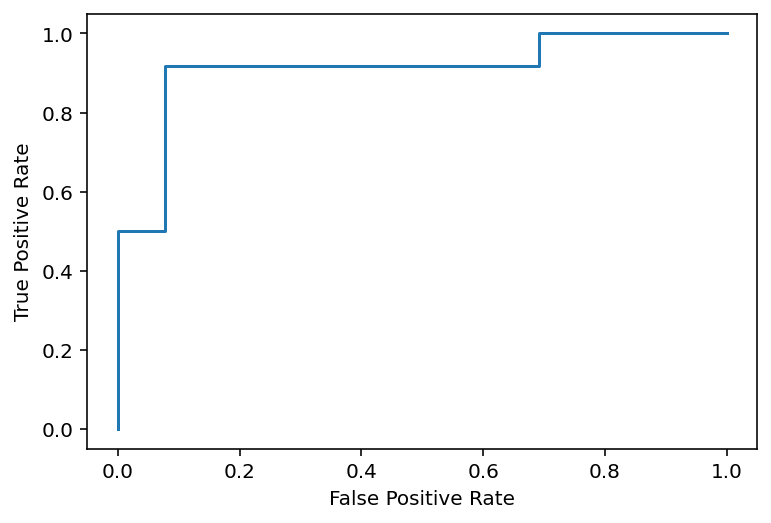

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
y_score = clf.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


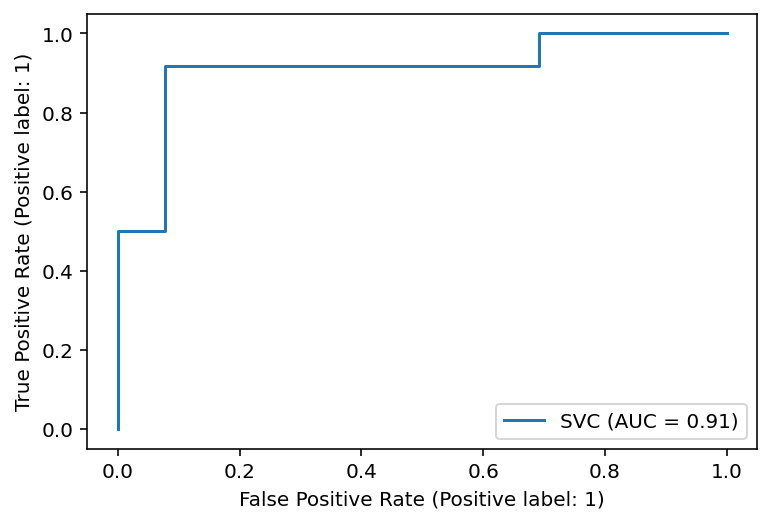

In [ ]:
import matplotlib.pyplot as plt  # doctest: +SKIP
from sklearn import datasets, metrics, model_selection, svm
X, y = datasets.make_classification(random_state=0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(            X, y, random_state=0)
clf = svm.SVC(random_state=0)
clf.fit(X_train, y_train)

metrics.plot_roc_curve(clf, X_test, y_test)  # doctest: +SKIP
plt.show()                                   # doctest: +SKIP

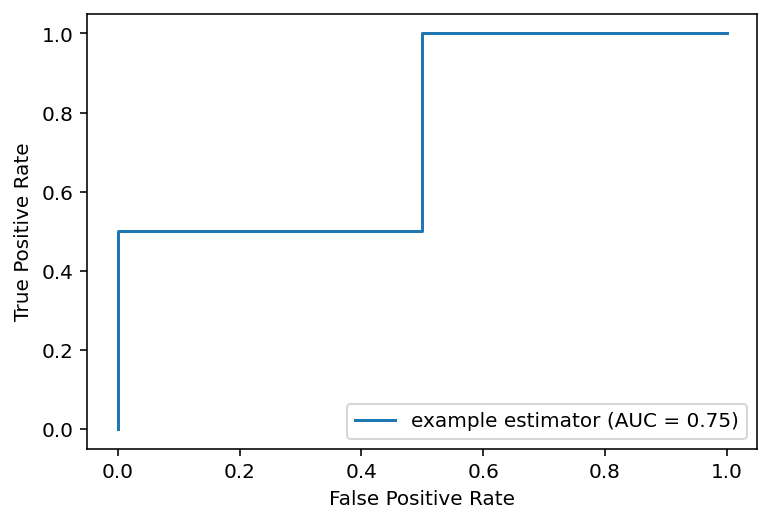

In [ ]:
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
y = np.array([0, 0, 1, 1])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,                                          estimator_name='example estimator')
display.plot()  # doctest: +SKIP
plt.show()      # doctest: +SKIP

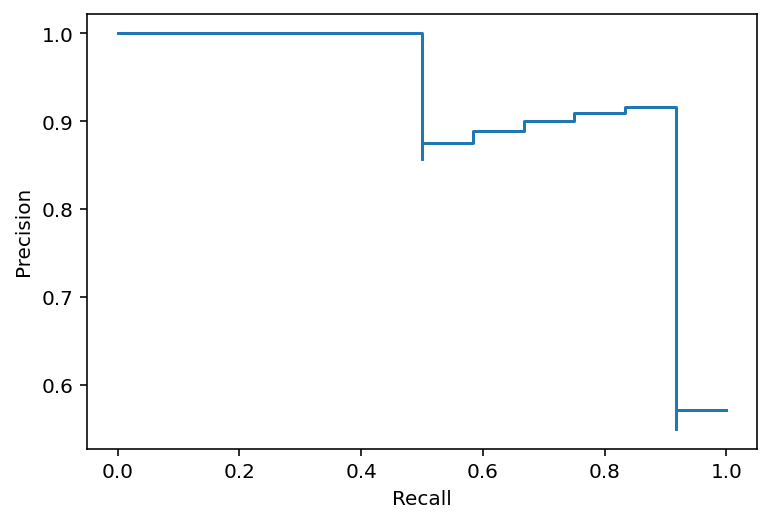

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_test, y_score,
                                         pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

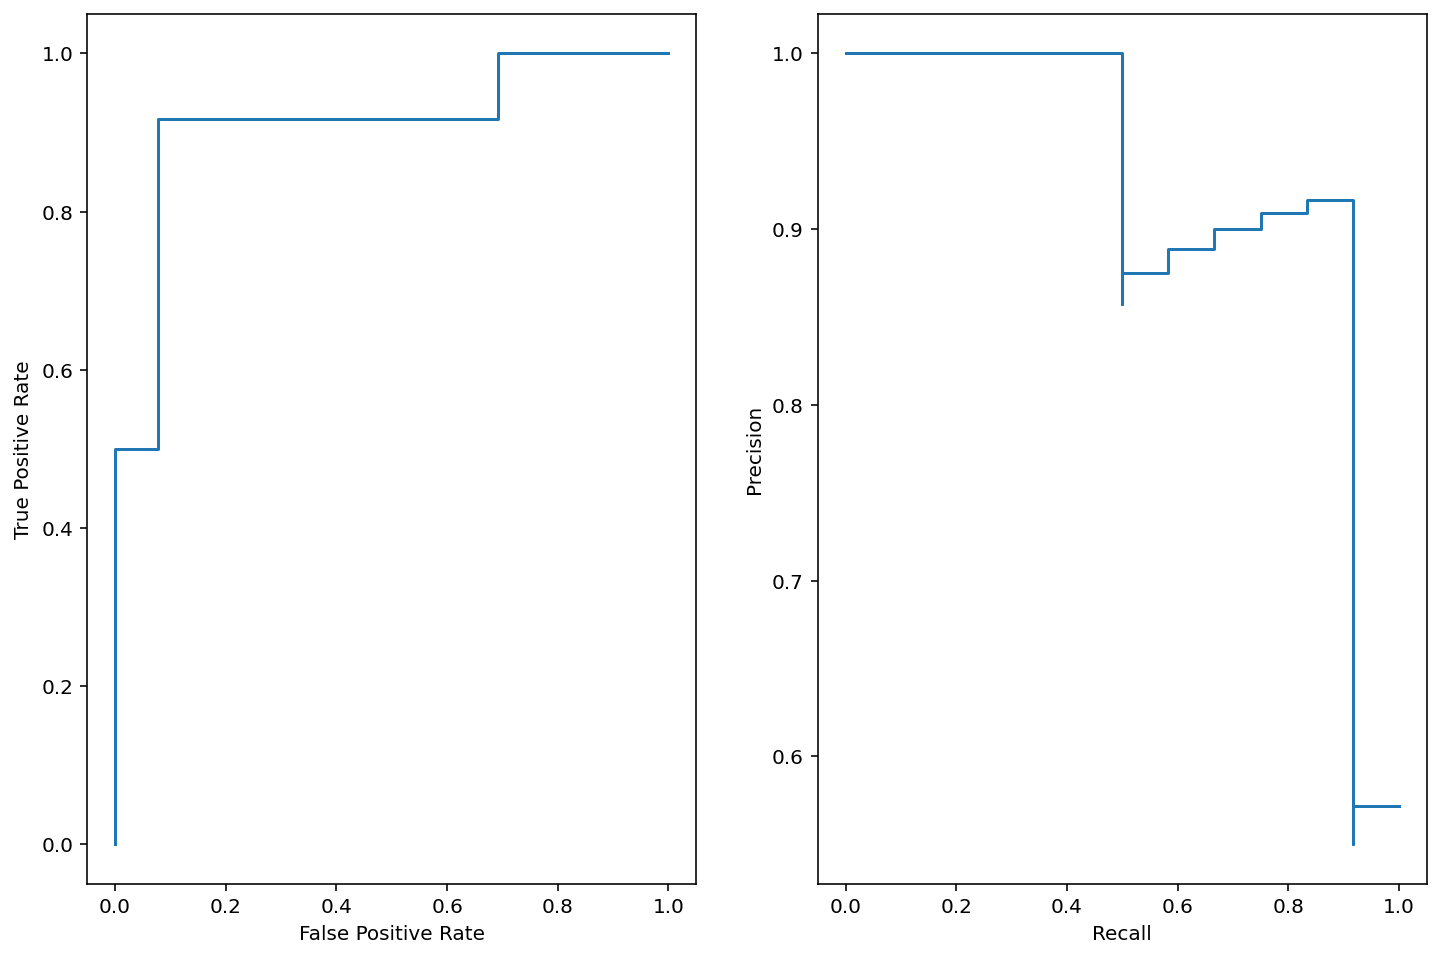

In [ ]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

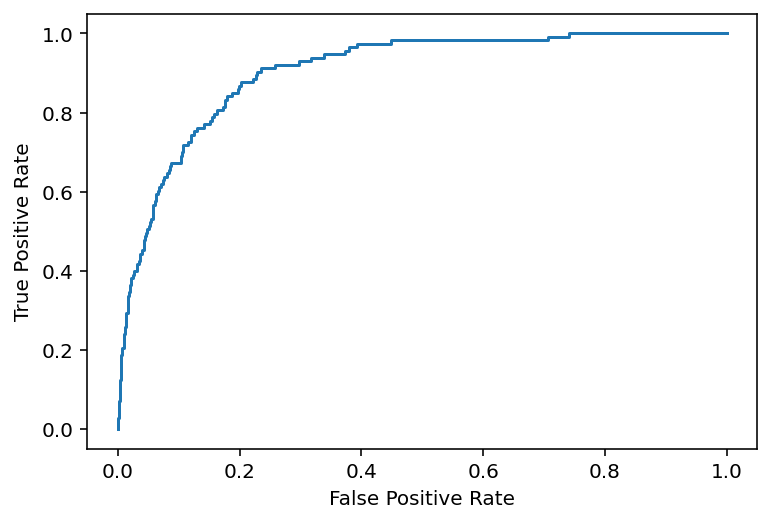

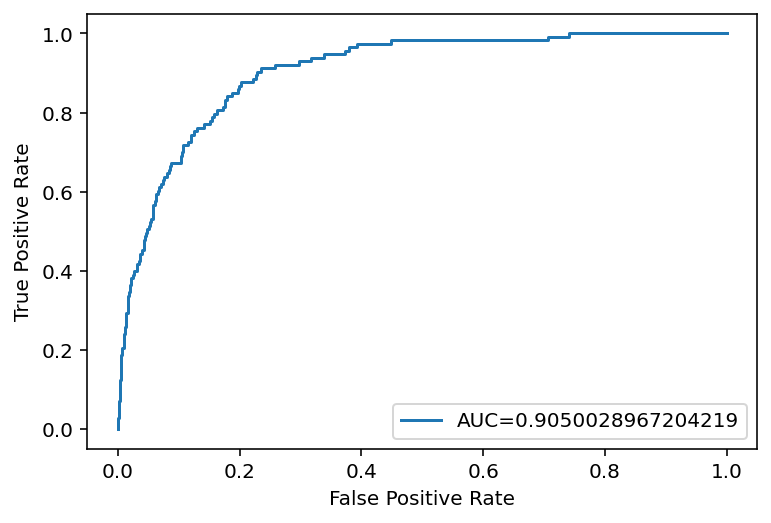

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
#import dataset from CSV file on Github
url = "https://raw.githubusercontent.com/Statology/Python-Guides/main/default.csv"
data = pd.read_csv(url)

#define the predictor variables and the response variable
X = data[['student', 'balance', 'income']]
y = data['default']

#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0)

#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,y_train)
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
#define metrics
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


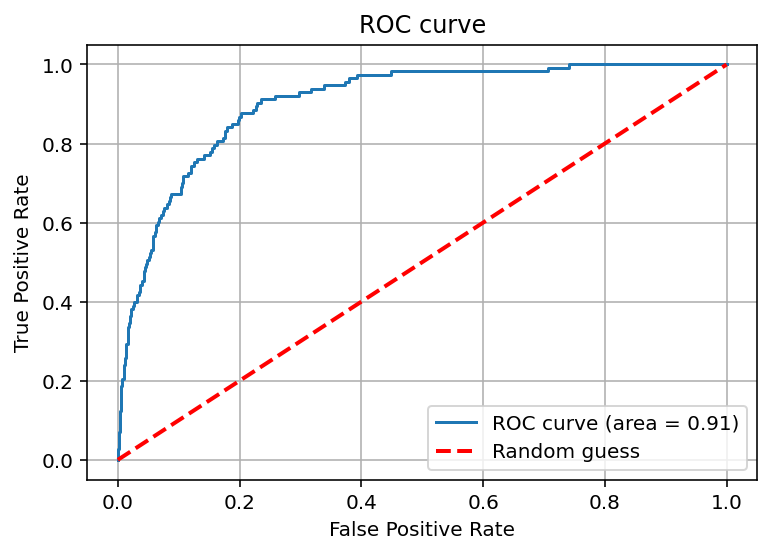

In [ ]:
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

382 74
torch.Size([624]) torch.Size([624])


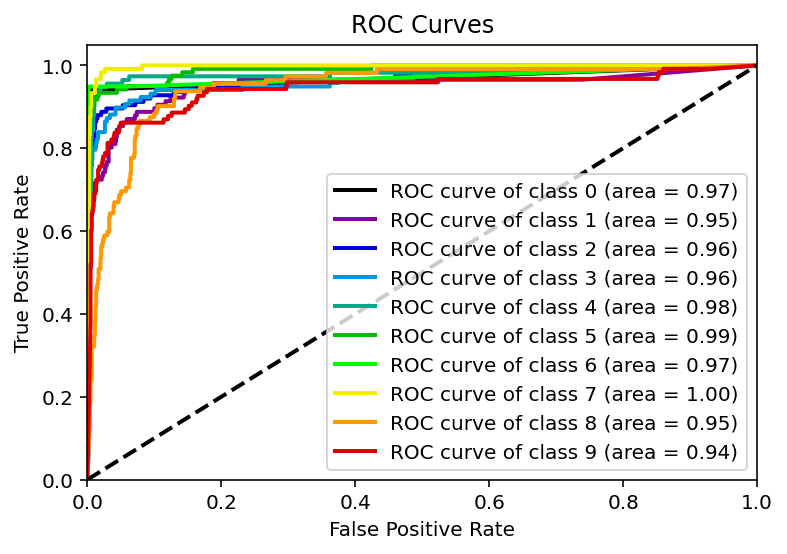

In [ ]:
# The codes below is partly copied from the code written by Matt Brem, Global Instructor at General Assembly.
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
print (TP,FP)
# Plot ROC curve.
print(y_true.shape, y_pred.shape)
import scikitplot as skplt #to make things easy
skplt.metrics.plot_roc(y_test, predicted_probas,plot_micro=False, plot_macro=False)
plt.show()

In [ ]:
def count_parameters(model_dens):
    return sum(p.numel() for p in model_dens.parameters() if p.requires_grad)

In [ ]:
print (count_parameters(model_dens))

29262914
